In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas_datareader.data import DataReader
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [24]:
symbol = 'AAPL'
start_date = datetime(2015,1,1)
end_date   = datetime(2021,1,1)

try:
    df = DataReader(symbol, 'stooq', start=start_date, end=end_date)
    df = df.sort_index()   # stooq returns reverse‐chronological by default
except Exception as e:
    raise RuntimeError(f"Failed to fetch {symbol} data from Stooq: {e}")

if df.empty:
    raise RuntimeError(f"No data returned for {symbol} between {start_date.date()} and {end_date.date()}")
    
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,24.7765,24.7882,23.8816,24.3203,239141317
2015-01-05,24.0857,24.1625,23.4499,23.6361,288860738
2015-01-06,23.7270,23.8975,23.2735,23.6381,295587842
2015-01-07,23.8500,24.0639,23.7319,23.9734,180109954
2015-01-08,24.2983,24.9519,24.1754,24.8927,266728489


In [25]:
df = df[['Close']]
print(f"Loaded {len(df)} rows for {symbol} from Stooq.")
df.head()

Loaded 1511 rows for AAPL from Stooq.


,Close
Date,
2015-01-02,24.3203
2015-01-05,23.6361
2015-01-06,23.6381
2015-01-07,23.9734
2015-01-08,24.8927


In [26]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(df.values)

SEQ_LEN = 60
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled, SEQ_LEN)
X = X.reshape((-1, SEQ_LEN, 1))

split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("X_train shape:", X_train.shape, "\nX_test shape:", X_test.shape)

X_train shape: (1160, 60, 1) 
X_test shape: (291, 60, 1)


In [27]:
def build_lstm():
    m = Sequential([
        LSTM(50, input_shape=(SEQ_LEN,1)),
        Dense(1)
    ])
    m.compile(optimizer='adam', loss='mse')
    return m

def build_gru():
    m = Sequential([
        GRU(50, input_shape=(SEQ_LEN,1)),
        Dense(1)
    ])
    m.compile(optimizer='adam', loss='mse')
    return m

def build_bilstm():
    m = Sequential([
        #Bidirectional(LSTM(50), input_shape=(SEQ_LEN,1)),
        Bidirectional(LSTM(50), input_shape=(SEQ_LEN,1)),
        Dropout(0.3),
        Dense(1)
    ])
    m.compile(optimizer='adam', loss='mse')
    return m

models = {
    'LSTM': build_lstm(),
    'GRU': build_gru(),
    'BiLSTM': build_bilstm()
}

C:\Users\subar\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\subar\anaconda3\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
history = {}
for name, model in models.items():
    print(f"Training {name}...")
    history[name] = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_split=0.1
    )

Training LSTM...
Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0087 - val_loss: 0.0034
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.4816e-04 - val_loss: 2.4588e-04
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.4476e-04 - val_loss: 1.5525e-04
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.2960e-04 - val_loss: 1.3357e-04
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.0757e-04 - val_loss: 1.5187e-04
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.1568e-04 - val_loss: 1.3750e-04
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.1225e-04 - val_loss: 1.3908e-04
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.0272e-04 - val_loss: 1.8083e-04
Epoch 9/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.6360e-05 - val_loss: 1.7168e-04
Epoch 10/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.1418e-05 - val_loss: 1.5079e-04
Training GRU...
Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 25m

In [29]:
metrics = {}
predictions = {}
true_prices = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

for name, model in models.items():
    pred = model.predict(X_test).flatten()
    pred_prices = scaler.inverse_transform(pred.reshape(-1,1)).flatten()
    mse = mean_squared_error(true_prices, pred_prices)
    mae = mean_absolute_error(true_prices, pred_prices)
    metrics[name] = {'MSE': mse, 'MAE': mae}
    predictions[name] = pred_prices

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


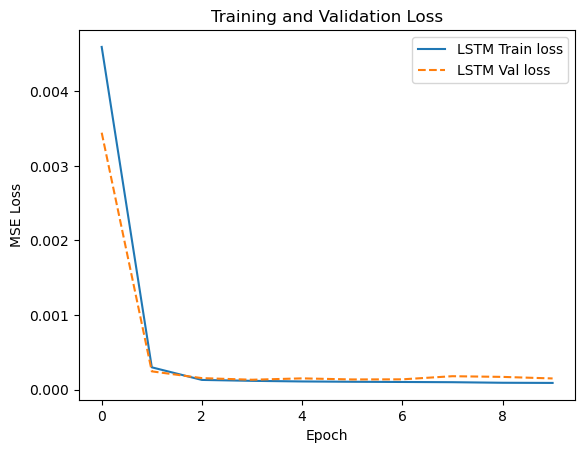

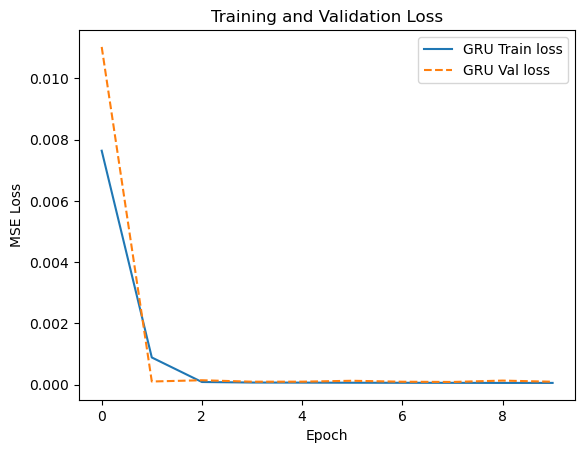

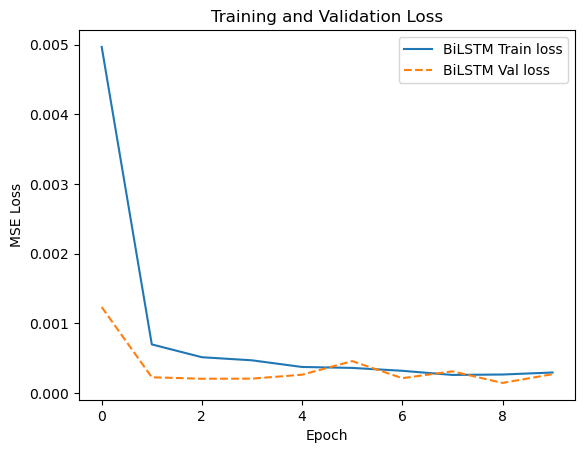

In [30]:
for name, hist in history.items():
    plt.plot(hist.history['loss'], label=f'{name} Train loss')
    plt.plot(hist.history['val_loss'], '--', label=f'{name} Val loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch');
    plt.ylabel('MSE Loss')
    plt.legend();
    plt.show()

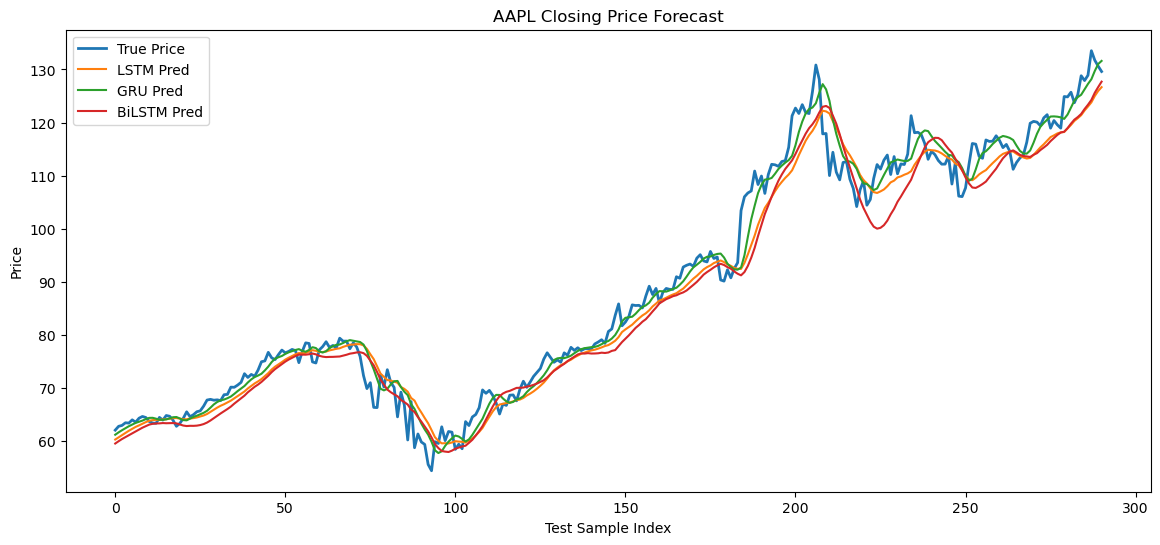

In [31]:
plt.figure(figsize=(14, 6))
plt.plot(true_prices, label='True Price', linewidth=2)
for name, pred in predictions.items():
    plt.plot(pred, label=f'{name} Pred')
plt.title(f'{symbol} Closing Price Forecast')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

In [32]:
metrics_df = pd.DataFrame(metrics).T
print(metrics_df)

              MSE       MAE
LSTM    16.841494  3.149514
GRU      9.460905  2.169926
BiLSTM  21.534968  3.689413
